In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import resnet as RN
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [15]:
import seaborn as sns

In [2]:
setup = "ce"
#setup = "soft"

In [5]:
model = RN.ResNet18()
if setup == "ce":
    path = './checkpoint/CrossEntropy.bin'
    npy_path = './CE.npy'
    npy_target = './CE_tar.npy'
    title = 'TSNE_CrossEntropy'
    states = torch.load(path)
elif setup == "soft":
    path = './checkpoint/LabelSmoothing.bin'
    npy_path = './LS.npy'
    npy_target = './LS_tar.npy'
    title = 'TSNE_LabelSmoothing'
    states = torch.load(path)


In [6]:
model.load_state_dict(states)
model.linear = nn.Flatten()

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

extract = model
extract.cuda()
extract.eval()

out_target = []
out_output = []

for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.cuda(), targets.cuda()
    outputs = extract(inputs)
    output_np = outputs.data.cpu().numpy()
    target_np = targets.data.cpu().numpy()
    out_output.append(output_np)
    out_target.append(target_np[:,np.newaxis])

output_array = np.concatenate(out_output, axis=0)
target_array = np.concatenate(out_target, axis=0)
np.save(npy_path, output_array, allow_pickle=False)
np.save(npy_target, target_array, allow_pickle=False)

Files already downloaded and verified


In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
tsne = TSNE(n_components=2, init='pca', random_state=0)
output_array = tsne.fit_transform(output_array)

Text(0.5, 1.0, 'TSNE_CrossEntropy')

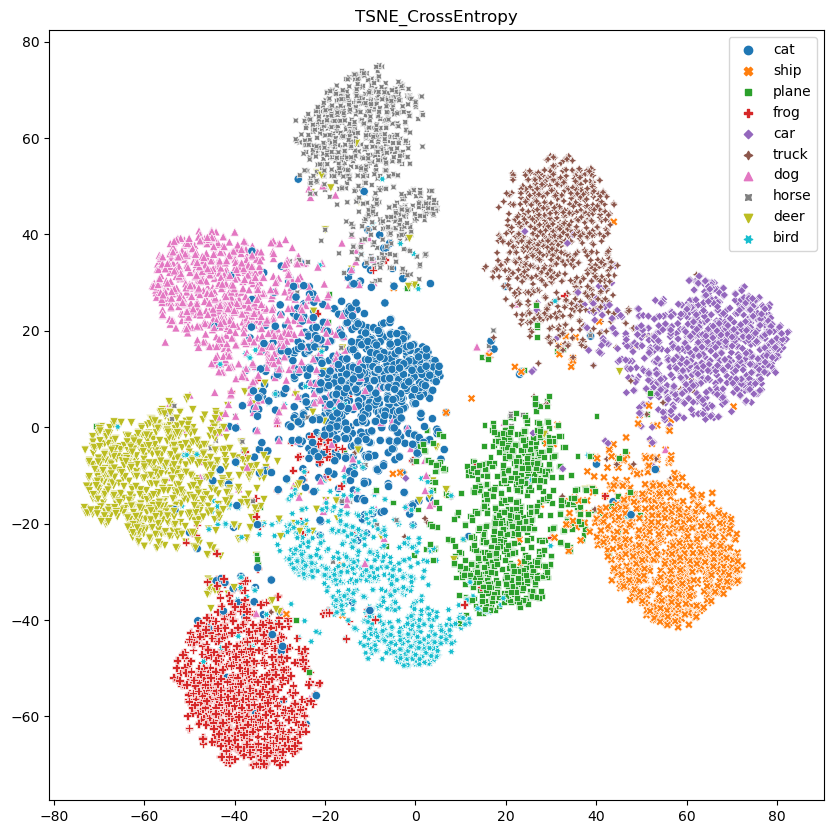

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(x=output_array[:, 0],y=output_array[:, 1],hue=[classes[i] for i in target_array[:,0]],style=[classes[i] for i in target_array[:,0]],ax=ax)
ax.set_title(title)

In [ ]:
fig.savefig('./'+title+'.png', bbox_inches='tight')